# Preprocessing Lung Cancer Dataset

First import the packages which will be used in this notebook:

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import dicom # working with the DICOM files
import os
import scipy.ndimage
from skimage import measure, morphology, segmentation # image processing

## Loading Data
Make sure that all the data are in the `data_folder`. Each patient has an associated folder of DICOM files. Let's read the dataset first.

In [2]:
def read_patient_data(patient_folder):
    patient_data = []
    for dcmfile in os.listdir(patient_folder):
        patient_data.append(dicom.read_file(patient_folder + '/' + dcmfile))
        patient_data
    patient_data.sort(key = lambda slice: float(slice.ImagePositionPatient[2]))
    return patient_data
    
data_folder = './sample_images/'
patients = os.listdir(data_folder)

Exploring the dataset by printing out metadata and viewing the slice images.

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113654.2.55.304178305453735054211675610177361641557
(0008, 0060) Modality                            CS: 'CT'
(0008, 103e) Series Description                  LO: 'Axial'
(0010, 0010) Patient's Name                      PN: '00cba091fa4ad62cc3200a657aeb957e'
(0010, 0020) Patient ID                          LO: '00cba091fa4ad62cc3200a657aeb957e'
(0010, 0030) Patient's Birth Date                DA: '19000101'
(0018, 0060) KVP                                 DS: ''
(0020, 000d) Study Instance UID                  UI: 2.25.86208730140539712382771890501772734277950692397709007305473
(0020, 000e) Series Instance UID                 UI: 2.25.11575877329635228925808596800269974740893519451784626046614
(0020, 0011) Series Number                       IS: '3'
(0020, 0012) Acquisition Number            

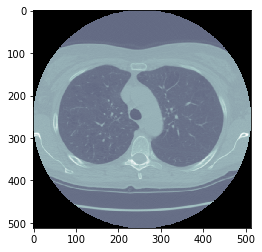

In [31]:
patient_data_sample = read_patient_data(data_folder + patients[0])
print(patient_data_sample[100]) # print out the metadata of a sample slice
plt.imshow(patient_data_sample[100].pixel_array, cmap=plt.cm.bone) # slice image
plt.show()

## Rescaling
The pixel values outside of the scanning domain in `pixel_array` are set to -2000. Here we set the values to 0 (corresponding to the value of air, whose Hounsfield unit is about -1000). Next, use the information iin `RescaleIntercept` and `RescaleSlope` to rescale the pixel data back to Hounsfield units which are used in original scannings.

In [33]:
def get_hounsfield_unit_array(patient_data):
    nx = patient_data[0].Rows
    ny = patient_data[0].Columns
    nz = len(patient_data)
    hu_array = np.zeros((nx, ny, nz), dtype=np.float32)
    for slice_index in range(len(patient_data)):
        intercept = patient_data[slice_index].RescaleIntercept
        slope = patient_data[slice_index].RescaleSlope
        pixel_array = patient_data[slice_index].pixel_array
        pixel_array[pixel_array == -2000] = 0
        hu_array[:,:,slice_index] = slope * pixel_array + intercept
        
    return hu_array.astype(np.int16)

hu_array_sample = get_hounsfield_unit_array(patient_data_sample)
print('Maximum HU: {:d}, Minmum HU: {:d}'.format(np.amax(hu_array_sample), np.amin(hu_array_sample)))

Maximum HU: 1616, Minmum HU: -1024


## Resampling
`PixelSpacing` of slices indicate the spacings between pixels in x- and y- direction. However, the spacing in z-direction is missing in the data. We could extract the information from `ImagePositionPatient`. Then, due to the fact that spacings are not the same across the whole dataset, we can resample the HU values with uniform spacings in all directions.

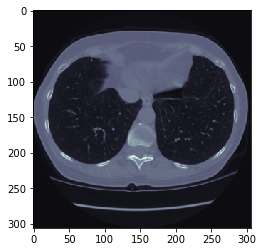

In [34]:
def resample_data(patient_data, new_spacings):
    # obtain original spacing in z-direction
    original_z_spacing = np.abs(patient_data[0].ImagePositionPatient[2]
                                - patient_data[1].ImagePositionPatient[2])
    # obtain rescaled HU array
    hu_array = get_hounsfield_unit_array(patient_data)
    
    original_spacings = np.array(patient_data[0].PixelSpacing + [original_z_spacing], dtype='float32')
    shape = hu_array.shape
    new_shape = np.round(hu_array.shape * original_spacings / new_spacings)
    zoom_factor = new_shape / hu_array.shape
    
    return scipy.ndimage.interpolation.zoom(hu_array, zoom_factor, mode='nearest')

new_spacings = [1, 1, 1] # unit: mm
resampled_patient_data_sample = resample_data(patient_data_sample, new_spacings)
plt.imshow(resampled_patient_data_sample[:,:,100], cmap=plt.cm.bone)
plt.show()

## Lung Segmentation
It is hard to segment the lung right. We not only need to separate the lung precisely, but also need to include possible nodules near the lung border regions, which are actually pretty common! A easy way is to apply a dilation morphological operation. Although we would be able to include possible nodules by using this simple method, we would also include many other tissues, which we are not interested in. Here, I'm using an improved but more complicated method to do lung segmentation. This method is using watershed, which is suggested by Ankasor in [this Kaggle Notebook](https://www.kaggle.com/ankasor/data-science-bowl-2017/improved-lung-segmentation-using-watershed/notebook). Instead of creating markers for 2D scan slices as done by Ankasor, I apply the method in the whole 3D scan, which could remove samll air pockets.

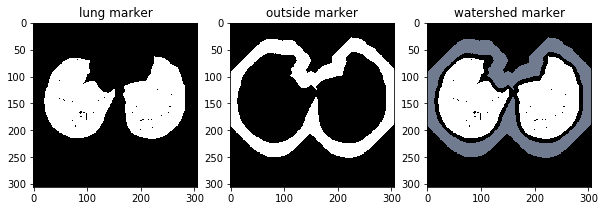

In [35]:
def create_markers(data):
    # create lung markers
    lung_marker = data < -400
    # remove the outside air
    for s in range(data.shape[2]):
        lung_marker[:,:,s] = segmentation.clear_border(lung_marker[:,:,s])
    lung_marker_labels = measure.label(lung_marker)
    potential_lung_regions = measure.regionprops(lung_marker_labels)
    potential_lung_regions.sort(key = lambda region: region.area)

    # only retain the largest regions (ideally corresponding to the lung)
    if (len(potential_lung_regions) > 1):
        assert (potential_lung_regions[-1].area > 20 * potential_lung_regions[-2].area)
    for region in potential_lung_regions[:-1]:
        coords_tuple = tuple([tuple(coord) for coord in region.coords.transpose()])
        lung_marker_labels[coords_tuple] = 0
    lung_marker = lung_marker_labels > 0

    # create outside markers
    outside_marker_inbound = scipy.ndimage.binary_dilation(lung_marker, iterations=8)
    outside_marker_outbound = scipy.ndimage.binary_dilation(lung_marker, iterations=35)
    outside_marker = outside_marker_outbound ^ outside_marker_inbound
    
    # create watershed markers (lung: 2, outside: 1)
    watershed_marker = lung_marker.astype(np.int16) * 2 + outside_marker.astype(np.int16) * 1
    
    return lung_marker, outside_marker, watershed_marker

lung_marker, outside_marker, watershed_marker = create_markers(resampled_patient_data_sample)

plt.figure(figsize=(10,5))
sample_slice_index = 100
plt.subplot(131)
plt.imshow(lung_marker[:,:,sample_slice_index], cmap=plt.cm.bone)
plt.title('lung marker')
plt.subplot(132)
plt.imshow(outside_marker[:,:,sample_slice_index], cmap=plt.cm.bone)
plt.title('outside marker')
plt.subplot(133)
plt.imshow(watershed_marker[:,:,sample_slice_index], cmap=plt.cm.bone)
plt.title('watershed marker')
plt.show()

Then we can use the markers created above to separate the lung by using watershed algorithm. 

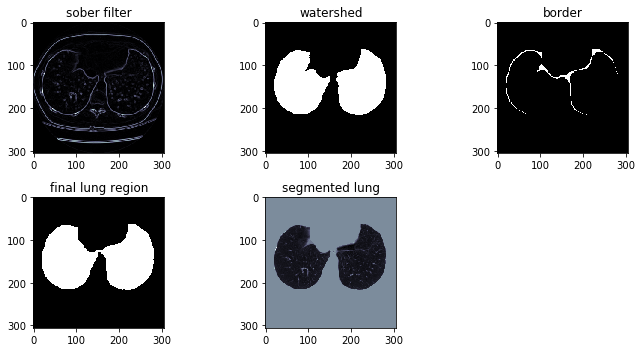

In [36]:
def slice_lung_segmentation(slice, lung_marker, watershed_marker):
    # find edges with Sober filters
    sober_x = scipy.ndimage.sobel(slice, axis=0)
    sober_y = scipy.ndimage.sobel(slice, axis=1)
    sober = np.hypot(sober_x, sober_y)

    # apply watershed algorithm to find watershed basins flooded from the markers
    watershed = morphology.watershed(sober, watershed_marker)
    
    # outline of watershed
    border = scipy.ndimage.morphological_gradient(watershed, size=(2,2)).astype(bool)
    
    # apply black tophat filter to include possible nodules near the lung border
    black_tophat = [[0, 0, 1, 1, 1, 0, 0],
                    [0, 1, 1, 1, 1, 1, 0],
                    [1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1],
                    [0, 1, 1, 1, 1, 1, 0],
                    [0, 0, 1, 1, 1, 0, 0]]
    black_tophat = scipy.ndimage.iterate_structure(black_tophat, 5)
    border += scipy.ndimage.black_tophat(border, structure=black_tophat)
    
    # combine the lung and the regions near its border which may contain nodules
    lung = np.bitwise_or(lung_marker, border)
    # remove the small air pockets inside the lung
    # lung = scipy.ndimage.morphology.binary_closing(lung, structure=np.ones((5,5)), iterations=4)
    lung = scipy.ndimage.binary_fill_holes(lung)
    
    return lung, sober, watershed, border

lung_marker, outside_marker, watershed_marker = create_markers(resampled_patient_data_sample)

sample_slice_index = 100
sample_slice = resampled_patient_data_sample[:,:,sample_slice_index]
lung, sober, watershed, border = slice_lung_segmentation(
    sample_slice,
    lung_marker[:,:,sample_slice_index],
    watershed_marker[:,:,sample_slice_index],
    )

plt.figure(figsize=(10,5))
plt.subplot(231)
plt.imshow(sober, cmap=plt.cm.bone)
plt.title('sober filter')
plt.subplot(232)
plt.imshow(watershed, cmap=plt.cm.bone)
plt.title('watershed')
plt.subplot(233)
plt.imshow(border, cmap=plt.cm.bone)
plt.title('border')
plt.subplot(234)
plt.imshow(lung, cmap=plt.cm.bone)
plt.title('final lung region')
plt.subplot(235)
segmented_slice = np.ones(sample_slice.shape) * 30
segmented_slice[lung] = sample_slice[lung]
plt.imshow(segmented_slice, cmap=plt.cm.bone)
plt.title('segmented lung')

plt.tight_layout()
plt.show()

Then, use the algorithm above to segment the lung for the whole 3D scan.

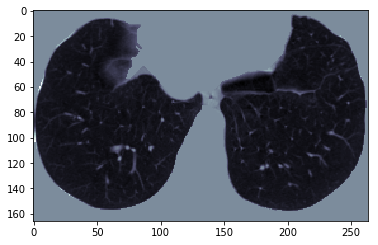

In [8]:
def lung_segmentation(data):
    # set HU outside the lung region to 30 (similar to the tissue HU around the lung)
    segmented_lung = np.ones(data.shape) * 30
    segmented_lung_marker = np.zeros(data.shape)
    
    lung_marker, outside_marker, watershed_marker = create_markers(data)
    
    for slice_index in range(data.shape[2]):
        slice = data[:,:,slice_index]
        slice_marker,_,_,_ = slice_lung_segmentation(slice,
                                                     lung_marker[:,:,slice_index],
                                                     watershed_marker[:,:,slice_index])
        segmented_lung_marker[:,:,slice_index] = slice_marker
        
    segmented_lung[segmented_lung_marker.astype(bool)] = data[segmented_lung_marker.astype(bool)]

    # crop the blank borders
    for x_begin in range(data.shape[0]):
        slice = segmented_lung_marker[x_begin,:,:]
        if not np.array_equal(slice, np.zeros(slice.shape)): break
    for x_end in range(-1,-data.shape[0]-1,-1):
        slice = segmented_lung_marker[x_end,:,:]
        if not np.array_equal(slice, np.zeros(slice.shape)): break
    for y_begin in range(data.shape[1]):
        slice = segmented_lung_marker[:,y_begin,:]
        if not np.array_equal(slice, np.zeros(slice.shape)): break
    for y_end in range(-1,-data.shape[1]-1,-1):
        slice = segmented_lung_marker[:,y_end,:]
        if not np.array_equal(slice, np.zeros(slice.shape)): break
    for z_begin in range(data.shape[2]):
        slice = segmented_lung_marker[:,:,z_begin]
        if not np.array_equal(slice, np.zeros(slice.shape)): break
    for z_end in range(-1,-data.shape[2]-1,-1):
        slice = segmented_lung_marker[:,:,z_end]
        if not np.array_equal(slice, np.zeros(slice.shape)): break

    if x_end == -1: x_end = -2
    if y_end == -1: y_end = -2
    if z_end == -1: z_end = -2

    return segmented_lung[x_begin:(x_end+1),y_begin:(y_end+1),z_begin:(z_end+1)]

segmented_lung_sample = lung_segmentation(resampled_patient_data_sample)

plt.imshow(segmented_lung_sample[:,:,63], cmap=plt.cm.bone)
plt.show()

## Reshaping
We notice that the array shapes are different for different patient. To make the shapes be the same, we pad zeros if the size is less than the desired size. If the size is greater than the desired size in z-direction, we trim the bottom part to fit the size. However, we make sure that the sizes are always less then desired sizes in x- and y- direction.

In [38]:
def reshape_data(segmented_lung, desired_shape):
    shape = list(segmented_lung.shape)
    diff = np.array(desired_shape) - np.array(shape)
    pad_width = []
    for i in range(3):
        before = (abs(diff[i])/2).astype(np.int16)
        after = abs(diff[i]) - before
        # make sure the size is not larger than the desired size
        if (i != 2): assert (diff[i] >= 0)
        if diff[i] > 0:
            pad_width.append((before, after))
        else:
            # trim the bottom part since studies show that lung nodules are less likely to
            # be cancerous in bottom and middle lobes
            pad_width.append((0,0))
            segmented_lung = segmented_lung[:,:,abs(diff[i]):]

    # pad zeros when the actual size is less than the desired size
    reshaped_data = np.lib.pad(segmented_lung, tuple(pad_width), 'constant', constant_values=30)
    assert (list(reshaped_data.shape) == desired_shape)
    
    return reshaped_data

desired_shape = [250, 350, 400]
reshaped_sample = reshape_data(segmented_lung_sample, desired_shape)


## Normalization
HU values above 400 are basically bones. So we only normalize the HU values between -1000 (air) and 400 (bone).

In [10]:
def normalize_data(reshaped_data, min_hu, max_hu):
    normalized_data = (reshaped_data - min_hu) / (max_hu - min_hu)
    normalized_data[normalized_data < 0.] = 0.
    normalized_data[normalized_data > 1.] = 1.
    return normalized_data
    
min_hounsfield_unit = -1000.
max_hounsfield_unit = 400.

normalized_sample = normalize_data(reshaped_sample,
                                   min_hounsfield_unit,
                                   max_hounsfield_unit)

## Zero-centering
Last, we subtract the mean from the normalized data to make it zero-centered. The value is about 0.35 which is estimated from the sample images.

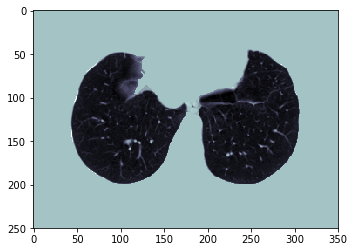

In [11]:
def zero_centering(data, mean):
    return data - mean

mean = 0.35
preprocessed_sample = zero_centering(normalized_sample, mean)
plt.imshow(preprocessed_sample[:,:,114], cmap=plt.cm.bone)
plt.show()

In [ ]:
for patient in patients:
    patient_data = read_patient_data(data_folder + patient)
    resampled_patient_data = resample_data(patient_data, new_spacings)
    segmented_lung = lung_segmentation(resampled_patient_data)
    reshaped_patient_data = reshape_data(segmented_lung, desired_shape)
    normalized_patient_data = normalize_data(reshaped_patient_data,
                                      min_hounsfield_unit,
                                      max_hounsfield_unit)
    preprocessed_patient_data = zero_centering(normalized_patient_data, mean)
    
    # print out the shape information
    print('Patient: ' + patient)
    print('Resampled shape: ({:3d},{:3d},{:3d}) \
        Segmented shape: ({:3d},{:3d},{:3d}) \
        Final shape: ({:3d},{:3d},{:3d})'.format(
        resampled_patient_data.shape[0],
        resampled_patient_data.shape[1],
        resampled_patient_data.shape[2],
        segmented_lung.shape[0],
        segmented_lung.shape[1],
        segmented_lung.shape[2],
        preprocessed_patient_data.shape[0],
        preprocessed_patient_data.shape[1],
        preprocessed_patient_data.shape[2],))
